In [106]:
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import math
import torch
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
from torch import nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
sns.set_theme(style="whitegrid")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [107]:
tsla_stock_data = yf.download('TSLA',start='2016-01-01',end='2022-01-01')
tsla_stock_data_close = tsla_stock_data[['Close']]
print(tsla_stock_data_close.head(),"\nshape:",tsla_stock_data_close.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
fit_data =scaler.fit_transform(tsla_stock_data_close.values.reshape(-1,1))
#print(fit_data[:5])


[*********************100%***********************]  1 of 1 completed
                Close
Date                 
2016-01-04  14.894000
2016-01-05  14.895333
2016-01-06  14.602667
2016-01-07  14.376667
2016-01-08  14.066667 
shape: (1511, 1)


Text(0.5, 1.0, 'TSLA stock price')

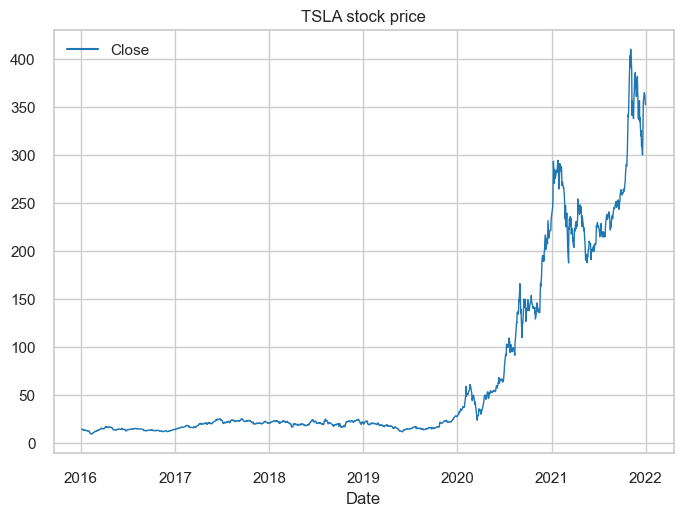

In [108]:
sns.lineplot(data = tsla_stock_data_close,palette="tab10", linewidth=1).set_title("TSLA stock price")

In [109]:
def split_data(data,num_day):
    X,y=[],[]
    for i in range(len(data)-num_day-1):
        X.append(data[i:(i+num_day),:])
        y.append(data[i+num_day,:])
    return np.array(X),np.array(y)
num_day = 30 
X,y = split_data(fit_data,num_day)
X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]
X_train=torch.from_numpy(X_train).type(torch.Tensor).to(device)
X_test=torch.from_numpy(X_test).type(torch.Tensor).to(device)
y_train=torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test=torch.from_numpy(y_test).type(torch.Tensor).to(device)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([1332, 30, 1])
torch.Size([148, 30, 1])
torch.Size([1332, 1])
torch.Size([148, 1])


In [110]:
input_dim = 1
hidden_dim = 64
num_layers = 2 
output_dim = 1

class LSTM (nn.Module):
    def __init__(self,input_dim,hidden_dim,num_layers,output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim,hidden_dim,num_layers, batch_first = True)
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(hidden_dim,output_dim)
    
    def forward(self,x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device="cuda").requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device="cuda").requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [111]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model.to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100,factor =0.5 ,min_lr=1e-7, eps=1e-08)
print(model)

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [112]:
num_epochs = 1000
hist = np.zeros(num_epochs)
seq_dim = num_day-1 


for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(X_train)
    
    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()

Epoch  10 MSE:  0.018606916069984436
Epoch  20 MSE:  0.0047011105343699455
Epoch  30 MSE:  0.0016531553119421005
Epoch  40 MSE:  0.0010109910508617759
Epoch  50 MSE:  0.0004618204548023641
Epoch  60 MSE:  0.00032222666777670383
Epoch  70 MSE:  0.0002550827048253268
Epoch  80 MSE:  0.00022096406610216945
Epoch  90 MSE:  0.00019286783935967833
Epoch  100 MSE:  0.00017624051542952657
Epoch  110 MSE:  0.00016169925220310688
Epoch  120 MSE:  0.00015181559138000011
Epoch  130 MSE:  0.00014571825158782303
Epoch  140 MSE:  0.00014193050446920097
Epoch  150 MSE:  0.0001388694508932531
Epoch  160 MSE:  0.0001362570037599653
Epoch  170 MSE:  0.0001340006128884852
Epoch  180 MSE:  0.00013196613872423768
Epoch  190 MSE:  0.00013008499809075147
Epoch  200 MSE:  0.00012832251377403736
Epoch  210 MSE:  0.00012665661051869392
Epoch  220 MSE:  0.0001250715577043593
Epoch  230 MSE:  0.0001235547970281914
Epoch  240 MSE:  0.00012209553096909076
Epoch  250 MSE:  0.00012068406795151532
Epoch  260 MSE:  0.00

In [113]:
y_test_pred = model(X_test)
y_train_pred = scaler.inverse_transform(y_train_pred.detach().to("cpu").numpy())
y_train = scaler.inverse_transform(y_train.detach().to("cpu").numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().to("cpu").numpy())
y_test = scaler.inverse_transform(y_test.detach().to("cpu").numpy())

trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.65 RMSE
Test Score: 9.89 RMSE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


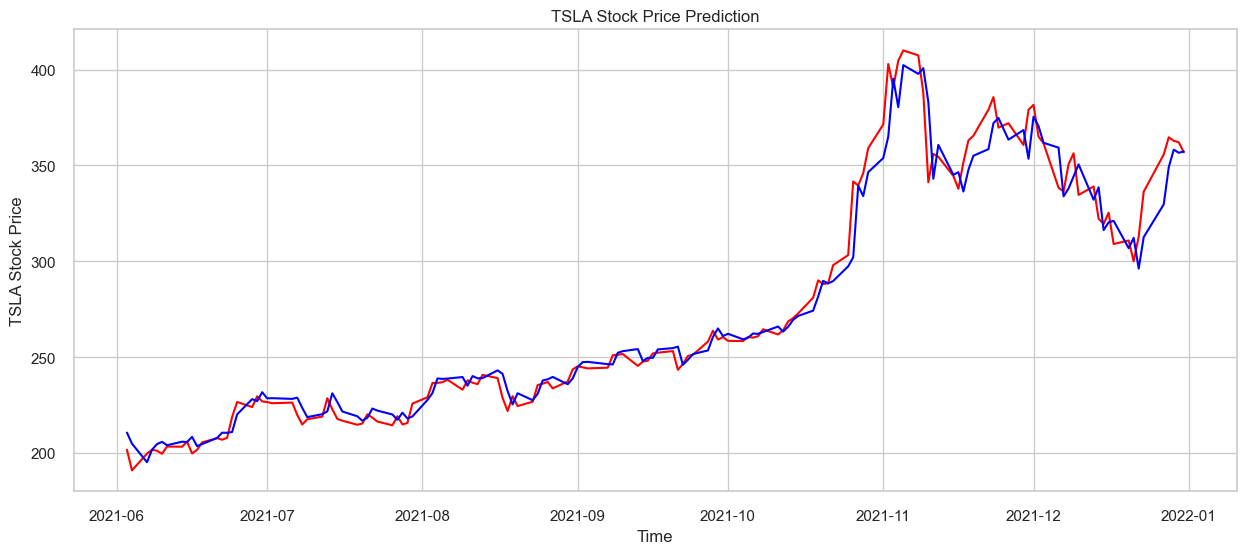

In [114]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(tsla_stock_data_close[len(tsla_stock_data_close)-len(y_test):].index, y_test, color = 'red')
axes.plot(tsla_stock_data_close[len(tsla_stock_data_close)-len(y_test):].index, y_test_pred, color = 'blue')
#axes.xticks(np.arange(0,394,50))
plt.title('TSLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TSLA Stock Price')
plt.legend()
plt.savefig('TSLA_pred.png')
plt.show()